# Tutorial 3.2. Response of a SDoF system 

### Description: In some cases a single degree of freedom - SDoF - model can be used to model the structural behaviour. The response of a SDoF system under dynamic loads may be computed by different direct time integration schemes, which are presented here. The results are compared with the analytical solutions from basic structural dynamics. Some exercises are proposed. 

#### Students are advised to complete the exercises. 

Project : Structural Wind Engineering WS19-20 
        Chair of Structural Analysis @ TUM - R. Wüchner, M. Péntek
        
Author : anoop.kodakkal@tum.de mate.pentek@tum.de

Created on:  15.11.2015

Last update: 13.11.2019

##### Contents

1. Structural response of a SDoF system under dynamic loads
2. Comparison with analytical solutions 
3. Comparison of the performance and accuracy of different numerical (time) integration schemes 

In [1]:
# import python modules
import time
import matplotlib.pyplot as plt
import numpy as np

# import own modules
import structure_sdof as s_sdof

#### Creating the time instances as an array

The start time, end time and the number of time steps are specified here for generating the time series. 

In [2]:
# start time
start_time = 0.0
# end time
end_time = 10.0
# steps 
n_steps = 100000
# time step
delta_time = end_time / (n_steps-1)
# time series
# generate grid size vectors 1D
time_series = np.arange(start_time, end_time + delta_time, delta_time)

### Modeling of the structure

<img src="example_sdof.png" alt="Drawing" style="width: 400px;"/>

### Dynamic analysis

The response of SDoF under dynamic loading is computed by different time integration schemes, three of which are presented in this section. 
1. __Generalised-Alpha__
2. __Euler First Order__
2. __Euler First and Second Order__

_THE OBJECT-ORIENTED GENERALIZED-ALPHA SOLVER
Implementation adapted from I. Hanzlicek (2014). Original implementation by M. Andre described in: Formulation of the Generalized-Alpha method for LAGRANGE. Technical Report, Chair of Structural Analysis @TUM, 2012.
See J. Chung, G.M. Hulbert: A time integration algorithm for structural dynamics
wih improved numerical dissipation: the generalized-aplha mehod. ASME J. Appl. 
Mech., 60:371-375,1993._

_THE EULER ALGORITHM USING FIRST AND SECOND ORDER APPROXIMATION
Implementation of the well-known finite difference approach, theory also
described in J.L. Cieslinski, B. Ratkiewicz: On the Simulations of the Classical
Harmonic Oscillator Equations by Difference Equations, PY 502, Hindawi Publishing 
Corporation, Advances in Difference Equations, Volume 2006. An algorithmic description
can also be found in H.P. Gavin: Numerical Integration in Structural Dynamics,
CEE 541, Structural Dynamics, Department of Civil & Environmental Engineering, 
Duke University Fall 2016._

###### Structural setup 

In [3]:
# mass
m = 0.1
# eigenfrequency
eigen_f = 10.0
# stiffness
k = m * (eigen_f * 2 * np.pi)**2
# damping ratio
# zero damping in this case
xi = 0.00 
# damping coefficient
b = xi * 2.0 * np.sqrt(m * k)

######  Initial conditions

In [4]:
# displacement
u0 = 1.0
# velocity
v0 = 0.0
# acceleration
a0 = 0.0

###### External loading  

Three types of loads are defined here: 
1. Free vibration case - No external loads
2. Harmonic excitation
3. Superposed signal

In [5]:
# sine with given amplitude = 1 and frequency = 10 Hz
sin_freq = 10
sin_ampl = 1
sin_series = sin_ampl * np.sin( 2 * np.pi * sin_freq * time_series)

# normal random signal with given mean m = 0 and standard dev std = 0.25 ->
rand_m = 0.0
rand_std = 0.25
rand_series = np.random.normal(rand_m, rand_std, len(time_series))

# constant signal with given amplitude = 10
const_ampl = 10
const_series = const_ampl * np.ones(len(time_series))

# superposing the above signals 
# superposition weighting
coef_signal1 = 1
coef_signal2 = 0.25
coef_signal3 = 0.25
superposed_series = coef_signal1 * const_series + coef_signal2 * sin_series + coef_signal3 * rand_series

zero_series = np.zeros(len(time_series))

# the external force: here choosing the zero_series, so no external load 
ext_force_series = zero_series

###### Let us plot the excitation force function 

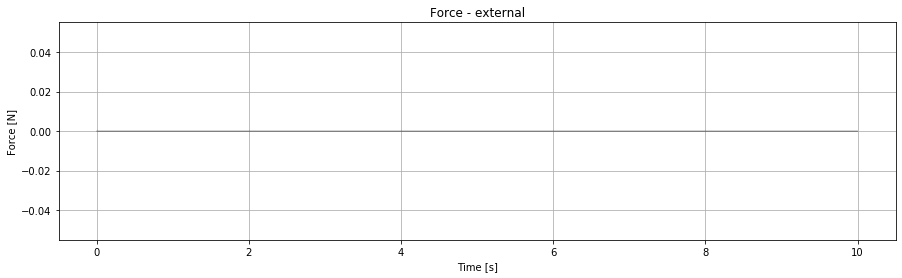

In [6]:
# plot for force
plt.figure(num=1, figsize=(15, 4))
plt.plot(time_series, ext_force_series, "-k", lw=0.5)
plt.ylabel('Force [N]')
plt.xlabel('Time [s]')
plt.title("Force - external")
plt.grid(True)

###### Analytical solutions  

Analytical solutions are available for 
1. Undamped free vibration with initial displacement 
2. Undamped forced vibration under harmonic excitation with no initial displacement 

Refer to: 

[A.K. Chopra, Dynamics of Structures: Theory and Applications to Earthquake Engineering, 
Person Prentice Hall, 2014](https://opac-ub-tum-de.eaccess.ub.tum.de/TouchPoint/perma.do?q=+1035%3D%22BV043635029%22+IN+%5B2%5D&v=tum&l=de)

[C. Petersen, Dynamik der Baukonstruktionen, 2017](https://link-springer-com.eaccess.ub.tum.de/book/10.1007%2F978-3-8348-2109-6) 

for detailed descriptions.

In [7]:
# undamped harmonic oscillation with only initial displacement
omega = np.sqrt(k / m)
u0an = 1.0
ampl = u0an**2 + (v0/omega)**2
theta = 0 #numpy.atan(u0an*omega/v0)
disp_analytic_wo_ext_force = ampl * np.sin(np.multiply(omega, time_series) + theta)
disp_analytic_wo_ext_force_limit = u0an * np.ones(len(time_series))

# undamped harmonic oscillation with only external force
u0an = 0
# u0 = 0, v0 = 0, omegaF = omega
disp_analytic_w_ext_force = np.zeros(len(time_series))
disp_analytic_w_ext_force_limit = np.zeros(len(time_series))
for i in range(len(time_series)):
    disp_analytic_w_ext_force[i] = sin_ampl /2/k * np.sin(omega * time_series[i])
    disp_analytic_w_ext_force[i] -= sin_ampl /2/k * (omega * time_series[i]) * np.sin(omega * time_series[i])
    
    disp_analytic_w_ext_force_limit[i] = sin_ampl /2/k * (omega * time_series[i])
    
delta_omega_ratio = 0.01
forcing_freq_ratio = np.arange(0.0, 3.0 + delta_omega_ratio, delta_omega_ratio)

def determine_transmissibility_funcion(forcing_freq_ratio, damping_ratio):
    transmissibility_function = np.zeros(len(forcing_freq_ratio))
    for i in range(len(forcing_freq_ratio)):
        numerator = np.sqrt(1 + (2 * damping_ratio * forcing_freq_ratio[i])**2)
        denominator = np.sqrt((1 - forcing_freq_ratio[i]**2)**2 + (2 * damping_ratio * forcing_freq_ratio[i])**2)
        
        transmissibility_function[i] = numerator / denominator     
    return transmissibility_function

###### Let us plot the function

For 1. Undamped free vibration with initial displacement

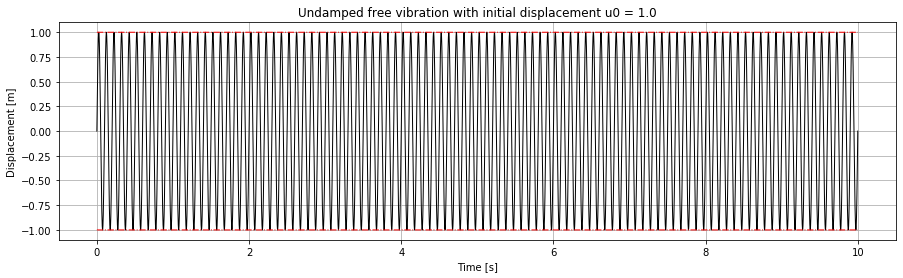

In [8]:
plt.figure(num=2, figsize=(15, 4))
plt.title('Undamped free vibration with initial displacement u0 = ' + str(u0))
plt.plot(time_series, disp_analytic_wo_ext_force, "-k", lw=1)
# upper and lower limits as straight red dashed lines
plt.plot(time_series, disp_analytic_wo_ext_force_limit, "-.r", lw=1)
plt.plot(time_series, -disp_analytic_wo_ext_force_limit, "-.r", lw=1)
# x_axis_end = end_time
# plt.xlim([0, x_axis_end])
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')
plt.grid(True)

Observe the limiting values of the function

For 2. Undamped force vibration under harmonic excitation with no initial displacement

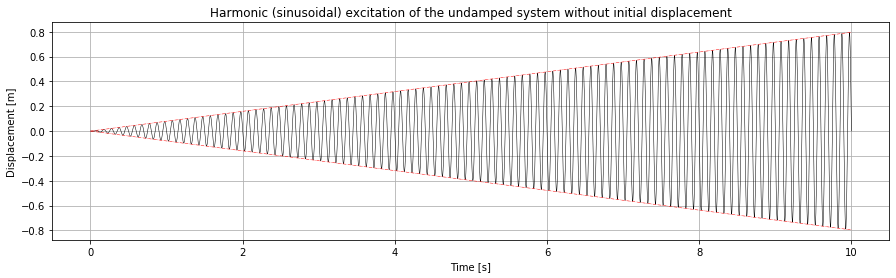

In [9]:
plt.figure(num=3, figsize=(15, 4))
plt.title('Harmonic (sinusoidal) excitation of the undamped system without initial displacement')
plt.plot(time_series, disp_analytic_w_ext_force, "-k", lw=0.5)
# upper and lower limits as straight red dashed lines
plt.plot(time_series, disp_analytic_w_ext_force_limit, "-.r", lw=0.5)
plt.plot(time_series, -disp_analytic_w_ext_force_limit, "-.r", lw=0.5)
# plt.xlim([0, x_axis_end])
plt.ylabel('Displacement [m]')
plt.xlabel('Time [s]')
plt.grid()

The dynamic amplification is dependent on the ratio of forcing frequency to eigen frequency

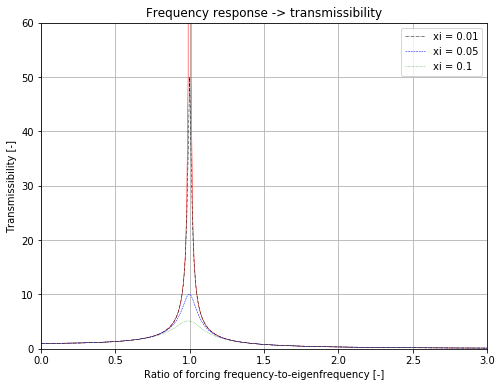

In [10]:
plt.figure(num=4, figsize=(8, 6))
plt.title('Frequency response -> transmissibility')
plt.plot(forcing_freq_ratio, 
         determine_transmissibility_funcion(forcing_freq_ratio, 0.00001),
         "-r", lw=0.5)
plt.plot(forcing_freq_ratio, 
         determine_transmissibility_funcion(forcing_freq_ratio, 0.01),
         "-.k", label="xi = 0.01", lw=0.5)
plt.plot(forcing_freq_ratio, 
         determine_transmissibility_funcion(forcing_freq_ratio, 0.05),
         "--b", label="xi = 0.05", lw=0.5)
plt.plot(forcing_freq_ratio, 
         determine_transmissibility_funcion(forcing_freq_ratio, 0.1),
         ":g", label="xi = 0.1", lw=0.5)
plt.xlim([forcing_freq_ratio[0], forcing_freq_ratio[-1]])
plt.ylim([0.0, 60.0])
plt.ylabel('Transmissibility [-]')
plt.xlabel('Ratio of forcing frequency-to-eigenfrequency [-]')
plt.legend(loc="best")
plt.grid(True)

##### Time integration schemes 

For solving the equation of motion at each time step different time integration schemes can be used.
Here in this exercise three time integration implementations are available. 
1. Euler 1st: The acceleration is approximated by 1st order Euler of velocity and the velocity is approximated by !st order Euler of displacement  
2. Euler 1st and 2nd: Here the acceleration is approximated by 2nd order Euler of displacements and the displacement is approximated by 1st order Euler of displacements. The forward, backward and central Euler are available for the velocities ( check block 12 for details)
3. A Generalized alpha method for time integration.  

In [11]:
# numerical parameter -> only needed for the GeneralizedAlpha time integration scheme
p_inf = 0.15
# create an object: structure - to be used by the GeneralizedAlpha scheme
structure = s_sdof.StructureSDOF(delta_time, m, b, k, p_inf, u0, v0, a0)
# structure.print_setup()

##### Tip: Have a look at "structure_sdof.py" for details 

In [12]:
# data for storing results
# using objects 
# standard python dictionaries would also be a good option
# create a SampleData class
class SampleData(): pass

# initiate objects and labels
data_euler1 = SampleData()
data_euler1.label = "Euler 1st" 

data_euler12 = SampleData()
data_euler12.label = "Euler 1st & 2nd" 

data_gen_alpha = SampleData()
data_gen_alpha.label = "Gen Alpha" 

# lists to store the results
data_euler1.disp = []
data_euler1.acc  = []
data_euler1.vel  = []

data_euler12.disp = []
data_euler12.acc  = []
data_euler12.vel  = []

data_gen_alpha.disp = []
data_gen_alpha.acc  = []
data_gen_alpha.vel  = []

# computation time for each method
data_euler1.computation_time = 0.0
data_euler12.computation_time = 0.0
data_gen_alpha.computation_time = 0.0
    
# initial values
data_euler1.disp.append(u0)
data_euler1.vel.append(v0)
data_euler1.acc.append(a0)

data_euler12.disp.append(u0)
data_euler12.vel.append(v0)
data_euler12.acc.append(a0)

data_gen_alpha.disp.append(u0)
data_gen_alpha.vel.append(v0)
data_gen_alpha.acc.append(a0)

# more initial values for the time integration schemes
data_euler1.un1 = u0
data_euler1.vn1 = v0   
data_euler1.an1 = a0  

data_euler12.un2 = u0
data_euler12.un1 = u0 - delta_time * v0 + delta_time**2 /2 * a0
data_euler12.vn1 = v0
data_euler12.an1 = a0 

###### Time loop: computing the response at each time instant
interested students may refer to [J.L. Cieslinski, B. Ratkiewicz](https://link.springer.com/content/pdf/10.1155%2FADE%2F2006%2F40171.pdf) (2006) for details on discretization of Euler time integration 

In [13]:
for i in range(1,len(time_series)):
    currentTime = time_series[i]
    
    #===========================================================================
    ## Euler 1st order   
    t = time.time()    

    # solve the time integration step 
    # first order approximation of acceleration and velocity, respectively    
    data_euler1.un0 = data_euler1.un1 + delta_time * data_euler1.vn1
    data_euler1.vn0 = data_euler1.vn1 + delta_time * data_euler1.an1
    data_euler1.an0 = 1/m * (ext_force_series[i] - b * data_euler1.vn0 - k * data_euler1.un0)

    # append results to list    
    data_euler1.disp.append(data_euler1.un0)
    data_euler1.vel.append(data_euler1.vn0)
    data_euler1.acc.append(data_euler1.an0)

    # update results    
    data_euler1.un1 = data_euler1.un0
    data_euler1.vn1 = data_euler1.vn0
    data_euler1.an1 = data_euler1.an0
    
    # elapsed time accumulated
    data_euler1.computation_time += time.time() - t
    
    #===========================================================================
    ## Euler 1st and 2nd order   
    t = time.time()    
 
    # solve the time integration step   
    # second order approximation of acceleration, first order for velocity
    # version 1 - eq. 5.3 
    # LHS = m
    # RHS = ext_force_series[i-1] * delta_time**2 
    # RHS += data_euler12.un1 * (2*m - b * delta_time - k *delta_time**2) 
    # RHS += data_euler12.un2 * (-m + b * delta_time)

    # version 2 - eq. 5.4 from J.L. Cieslinski, B. Ratkiewicz or eq. 6 from H.P. Gavin 
    LHS = m + b * delta_time/2
    RHS = ext_force_series[i-1] * delta_time**2 
    RHS += data_euler12.un1 * (2*m - k * delta_time**2) 
    RHS += data_euler12.un2 * (-m + b * delta_time /2)

    # version 3 - eq. 5.5
    # LHS = m + b * delta_time
    # RHS = ext_force_series[i-1] * delta_time**2 
    # RHS += data_euler12.un1 * (2*m + b * delta_time - k * delta_time**2) 
    # RHS += data_euler12.un2 * (-m)

    data_euler12.un0 = RHS/LHS
    
    data_euler12.vn0 = (data_euler12.un0 - data_euler12.un2) /2 /delta_time
    data_euler12.an0 = (data_euler12.un0 - 2 * data_euler12.un1 + data_euler12.un2) / delta_time**2

    # append results to list   
    data_euler12.disp.append(data_euler12.un0)
    data_euler12.vel.append(data_euler12.vn0)
    data_euler12.acc.append(data_euler12.an0)

    # update results
    data_euler12.un2 = data_euler12.un1    
    data_euler12.un1 = data_euler12.un0
    
    # elapsed time accumulated
    data_euler12.computation_time += time.time() - t   
    
    #===========================================================================
    ## Generalized Alpha     
    t = time.time()    

    # solve the time integration step
    structure.solve_structure(ext_force_series[i])

    # append results to list
    data_gen_alpha.disp.append(structure.get_displacement())
    data_gen_alpha.vel.append(structure.get_velocity())
    data_gen_alpha.acc.append(structure.get_acceleration())

    # update results
    structure.update_structure_timestep()
    
    # elapsed time accumulated
    data_gen_alpha.computation_time += time.time() - t 

In [14]:
# print computation time
print('# Computation time')
print('Euler 1st order: ' + str(data_euler1.computation_time) + ' s')
print('Euler 1st & 2nd order: ' + str(data_euler12.computation_time) + ' s')
print('Generalized Alpha: ' + str(data_gen_alpha.computation_time) + ' s') 
print()

# Computation time
Euler 1st order: 0.3208191394805908 s
Euler 1st & 2nd order: 0.7055478096008301 s
Generalized Alpha: 0.8354706764221191 s



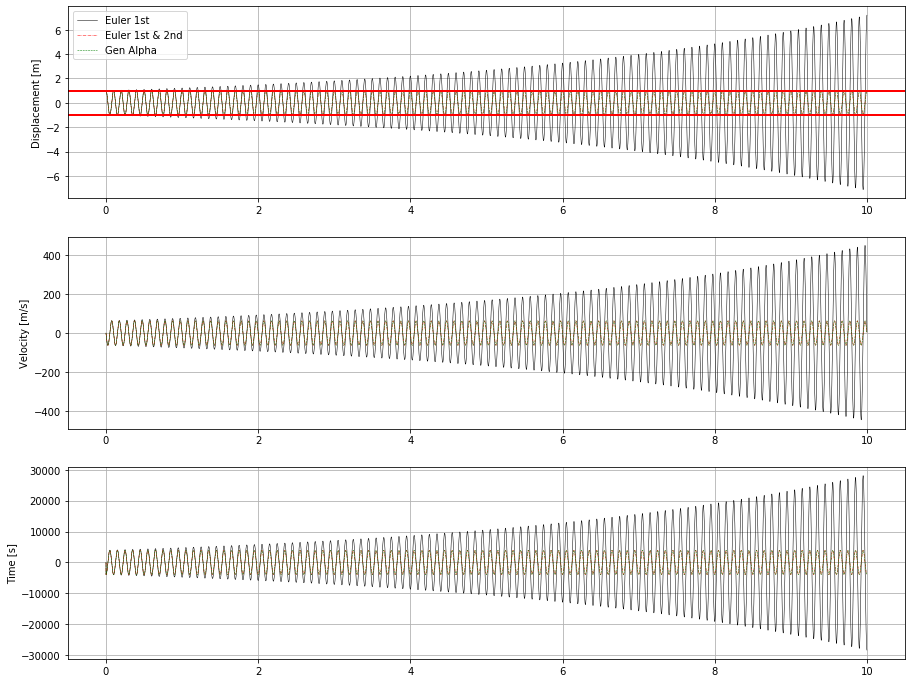

In [15]:
plt.figure(num=5, figsize=(15, 12))

# subplot for displacement
plt.subplot(3, 1, 1)
plt.plot(time_series, data_euler1.disp, "-k", label=data_euler1.label, lw=0.5)
plt.plot(time_series, data_euler12.disp, "-.r", label=data_euler12.label, lw=0.5)
plt.plot(time_series, data_gen_alpha.disp, "--g", label=data_gen_alpha.label, lw=0.5)
# plt.xlim([0, x_axis_end])
plt.ylabel('Displacement [m]')
plt.axhline(y=u0, linewidth=2, color = 'r')
plt.axhline(y=-u0, linewidth=2, color = 'r')
plt.legend(loc="best")
plt.grid(True)

# subplot for velocity
plt.subplot(3, 1, 2)
plt.plot(time_series, data_euler1.vel, "-k", label=data_euler1.label, lw=0.5)
plt.plot(time_series, data_euler12.vel, "-.r", label=data_euler12.label, lw=0.5)
plt.plot(time_series, data_gen_alpha.vel, "--g", label=data_gen_alpha.label, lw=0.5)
# plt.xlim([0, x_axis_end])
plt.ylabel('Velocity [m/s]')
plt.grid(True)

# subplot for acceleration
plt.subplot(3, 1, 3)
plt.plot(time_series, data_euler1.acc, "-k", label=data_euler1.label, lw=0.5)
plt.plot(time_series, data_euler12.acc, "-.r", label=data_euler12.label, lw=0.5)
plt.plot(time_series, data_gen_alpha.acc, "--g", label=data_gen_alpha.label, lw=0.5)
# plt.xlim([0, x_axis_end])
plt.ylabel('Acceleration [m/s^2]')
plt.xlabel('Time [s]')
plt.grid(True)

plt.show()

### Exercise 1: Euler 1st order

Reduce the time step by changing the number of steps n_steps. What do you observe about the numerical stability of Euler 1st order time integration scheme? 

Modify the time step delta_time by changing the number of timesteps 'n_steps'. Comment on the results. 

### Exercise 2: Modify p_inf

Modify the numerical parameter p_inf (for the Generalized Alpha scheme), observe and comment on the result.

### Exercise 3: Apply harmonic loads

Apply harmonic loads and compare with the analytical results. 

## Check Point: Discussion


#### Discuss among groups the observations and outcomes regarding the exercises.